# FactShield: Feature Engineering

**Purpose:** Convert text into numerical features for machine learning

## What We'll Build:

### Part A: TF-IDF Vectorization
- Convert processed text into numerical matrix
- Extract top 5,000 most important words
- Save vectorizer for later use

### Part B: Sentiment Analysis (OUR UNIQUE FEATURE!)
- Extract emotional features
- Detect manipulation patterns
- Compare fake vs real news sentiment

### Part C: Combine Features
- Merge TF-IDF + Sentiment features
- Save complete feature matrices
- Ready for model training!

---

## Step 1: Load Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Sentiment analysis
from textblob import TextBlob

# Saving models
import joblib

# Matrix operations
from scipy.sparse import hstack, save_npz, load_npz

# Statistics
from scipy import stats

# Path handling
from pathlib import Path

# Settings
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_style('whitegrid')

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## Step 2: Load Processed Data

In [2]:
# Load processed datasets (with portable path finding)
print("Loading processed datasets...\n")

# SIMPLE SOLUTION: Search for train.csv globally (same approach as 01_quick_start.ipynb)
print("Searching for processed data files...")

# Search from home directory for train.csv in data/processed folder
found_data = None
for csv_file in Path.home().rglob('train.csv'):
    # Check if it's in a 'processed' folder with val.csv and test.csv
    if (csv_file.parent.name == 'processed' and 
        (csv_file.parent / 'val.csv').exists() and 
        (csv_file.parent / 'test.csv').exists()):
        found_data = csv_file.parent
        break
    # Limit search to avoid being too slow
    if len([f for f in Path.home().rglob('train.csv')]) > 10:
        break

if not found_data:
    raise FileNotFoundError(
        "Could not find processed data files (train.csv, val.csv, test.csv). "
        "Please make sure you've run 02_data_preprocessing.ipynb first."
    )

# Load data
data_path = found_data
print(f"✅ Found processed data!\n")
print(f"Loading from: {data_path}\n")

train_df = pd.read_csv(data_path / 'train.csv')
val_df = pd.read_csv(data_path / 'val.csv')
test_df = pd.read_csv(data_path / 'test.csv')

print(f"✅ Loaded datasets:")
print(f"   Training:   {len(train_df):,} articles")
print(f"   Validation: {len(val_df):,} articles")
print(f"   Test:       {len(test_df):,} articles")

print(f"\nColumns before cleanup: {len(train_df.columns)} columns")

# Fix: The CSV got corrupted with extra columns
# Keep only the columns we need
needed_columns = ['title', 'text', 'processed_text', 'label', 'subject', 'date', 'word_count']

# Check which columns exist and keep only those
train_df = train_df[[col for col in needed_columns if col in train_df.columns]]
val_df = val_df[[col for col in needed_columns if col in val_df.columns]]
test_df = test_df[[col for col in needed_columns if col in test_df.columns]]

print(f"Columns after cleanup: {list(train_df.columns)}")
print(f"\n✅ Data cleaned - using only necessary columns")

print(f"\nSample processed text:")
print(train_df['processed_text'].iloc[0][:200] + "...")

Loading processed datasets...

Searching for processed data files...
✅ Found processed data!

Loading from: C:\Users\btakiso\.cache\kagglehub\datasets\clmentbisaillon\fake-and-real-news-dataset\versions\processed

✅ Loaded datasets:
   Training:   31,343 articles
   Validation: 6,716 articles
   Test:       6,717 articles

Columns before cleanup: 7 columns
Columns after cleanup: ['title', 'text', 'processed_text', 'label', 'subject', 'date', 'word_count']

✅ Data cleaned - using only necessary columns

Sample processed text:
illegal alien accused running million food stamp scam cut gps braceletmanhunt underway state police are searching for fugitive accused running milliondollar food stamp scam after they say cut off his ...


---

# PART A: TF-IDF Vectorization

## What is TF-IDF?

**TF-IDF** (Term Frequency-Inverse Document Frequency) converts text into numbers by:
- **TF (Term Frequency):** How often a word appears in a document
- **IDF (Inverse Document Frequency):** How rare/common a word is across all documents

**Result:** Important, specific words get high scores; common words get low scores.

---

## Step 3: Create TF-IDF Vectorizer

In [3]:
# Create TF-IDF Vectorizer
print("Creating TF-IDF Vectorizer...\n")

vectorizer = TfidfVectorizer(
    max_features=5000,      # Keep top 5000 most important words
    ngram_range=(1, 2),     # Use single words AND word pairs
    min_df=5,               # Word must appear in at least 5 documents
    max_df=0.8,             # Ignore words appearing in >80% of documents
    sublinear_tf=True       # Use logarithmic scaling for term frequency
)

print("✅ Vectorizer created with settings:")
print(f"   Max features: 5,000 words/phrases")
print(f"   N-gram range: (1, 2) - single words and word pairs")
print(f"   Min document frequency: 5")
print(f"   Max document frequency: 0.8 (80%)")
print(f"\n💡 This will create a matrix of shape: (num_articles × 5000)")

Creating TF-IDF Vectorizer...

✅ Vectorizer created with settings:
   Max features: 5,000 words/phrases
   N-gram range: (1, 2) - single words and word pairs
   Min document frequency: 5
   Max document frequency: 0.8 (80%)

💡 This will create a matrix of shape: (num_articles × 5000)


## Step 4: Fit Vectorizer on Training Data

**Important:** We only fit on TRAINING data to avoid data leakage!

In [4]:
print("Fitting TF-IDF vectorizer on training data...")
print("This may take 1-2 minutes...\n")

# Fit and transform training data
X_train_tfidf = vectorizer.fit_transform(train_df['processed_text'])

print("✅ Vectorizer fitted!\n")
print(f"Training matrix shape: {X_train_tfidf.shape}")
print(f"   {X_train_tfidf.shape[0]:,} articles")
print(f"   {X_train_tfidf.shape[1]:,} features (words/phrases)")
print(f"\nMatrix sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")
print(f"(Most values are 0 - text is sparse!)")

Fitting TF-IDF vectorizer on training data...
This may take 1-2 minutes...

✅ Vectorizer fitted!

Training matrix shape: (31343, 5000)
   31,343 articles
   5,000 features (words/phrases)

Matrix sparsity: 96.22%
(Most values are 0 - text is sparse!)


## Step 5: Transform Validation & Test Data

In [5]:
print("Transforming validation and test data...\n")

# Transform (NOT fit_transform!) validation and test data
X_val_tfidf = vectorizer.transform(val_df['processed_text'])
X_test_tfidf = vectorizer.transform(test_df['processed_text'])

print("✅ All datasets transformed!\n")
print(f"Training:   {X_train_tfidf.shape}")
print(f"Validation: {X_val_tfidf.shape}")
print(f"Test:       {X_test_tfidf.shape}")
print(f"\n💡 All have {X_train_tfidf.shape[1]:,} features (same vocabulary)")

Transforming validation and test data...

✅ All datasets transformed!

Training:   (31343, 5000)
Validation: (6716, 5000)
Test:       (6717, 5000)

💡 All have 5,000 features (same vocabulary)


## Step 6: Analyze Vocabulary - Top Words

In [6]:
# Get feature names (words/phrases)
feature_names = vectorizer.get_feature_names_out()

print(f"Total vocabulary size: {len(feature_names):,} words/phrases\n")

# Show some examples
print("Sample single words:")
single_words = [f for f in feature_names if ' ' not in f][:20]
print(single_words)

print("\nSample word pairs (bigrams):")
bigrams = [f for f in feature_names if ' ' in f][:20]
print(bigrams)

# Calculate average TF-IDF scores per feature
mean_tfidf = np.asarray(X_train_tfidf.mean(axis=0)).flatten()
top_indices = mean_tfidf.argsort()[-20:][::-1]

print("\n🔥 Top 20 most important words/phrases (by average TF-IDF score):")
for idx in top_indices:
    print(f"   {feature_names[idx]:30} → {mean_tfidf[idx]:.4f}")

Total vocabulary size: 5,000 words/phrases

Sample single words:
['abc', 'abe', 'abedin', 'ability', 'able', 'abortion', 'about', 'above', 'abroad', 'absolute', 'absolutely', 'abuse', 'academic', 'accept', 'accepted', 'access', 'accord', 'according', 'account', 'accountable']

Sample word pairs (bigrams):
['abc news', 'about her', 'about his', 'about how', 'about percent', 'about that', 'about the', 'about their', 'about this', 'about trump', 'about what', 'about whether', 'access the', 'according the', 'accused the', 'across the', 'action the', 'added that', 'added the', 'adding that']

🔥 Top 20 most important words/phrases (by average TF-IDF score):
   trump                          → 0.0340
   said                           → 0.0310
   with                           → 0.0290
   his                            → 0.0265
   not                            → 0.0248
   this                           → 0.0242
   from                           → 0.0241
   have                           → 0.0

## Step 7: Visualize TF-IDF Distribution

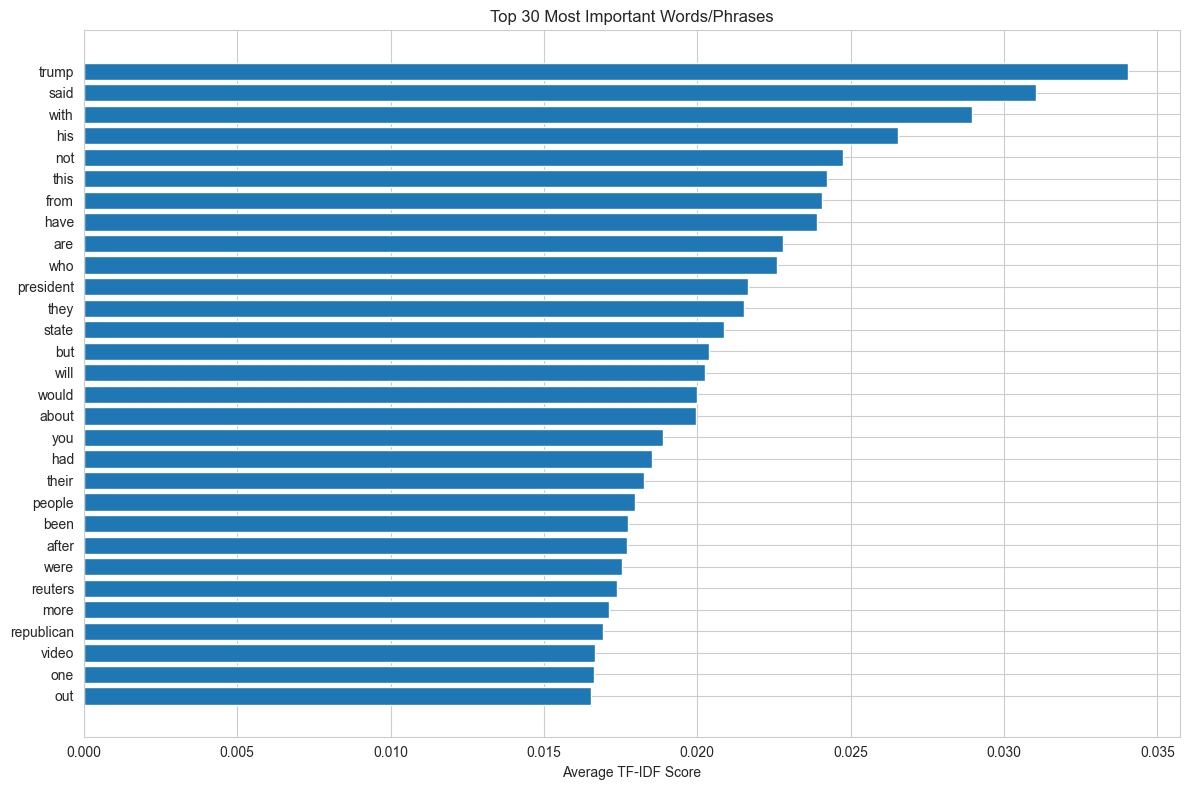

✅ These words are most distinctive across articles!


In [7]:
# Visualize top features
mean_tfidf = np.asarray(X_train_tfidf.mean(axis=0)).flatten()
top_indices = mean_tfidf.argsort()[-30:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_scores = mean_tfidf[top_indices]

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_scores)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Average TF-IDF Score')
plt.title('Top 30 Most Important Words/Phrases')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("✅ These words are most distinctive across articles!")

## Step 8: Save TF-IDF Vectorizer

In [20]:
# Save vectorizer for later use
# SMART APPROACH: Since we already found the data, use that to find project root!
def find_models_dir():
    """Find or create the models directory - uses the SAME location where we found data"""
    # Strategy: Find where train.csv is, go up to project root, create models there
    
    # Search for train.csv but SKIP cache directories!
    found_data = None
    for csv_file in Path.home().rglob('train.csv'):
        # Skip cache directories (kagglehub, pip cache, etc.)
        if '.cache' in str(csv_file) or 'kagglehub' in str(csv_file):
            continue
            
        # Check if it's in a 'processed' folder with val.csv and test.csv
        if ((csv_file.parent / 'val.csv').exists() and 
            (csv_file.parent / 'test.csv').exists()):
            found_data = csv_file.parent
            break
        # Limit search
        if len([f for f in Path.home().rglob('train.csv')]) > 10:
            break
    
    if not found_data:
        raise FileNotFoundError("Could not find processed data. Please run 02_data_preprocessing.ipynb first.")
    
    # Found data! Now go up to project root
    # If data is in: /path/to/project/data/processed/train.csv
    # Then models should be: /path/to/project/models/
    data_folder = found_data.parent  # Go up from 'processed' to 'data'
    project_root = data_folder.parent  # Go up from 'data' to project root
    models_folder = project_root / 'models'
    models_folder.mkdir(exist_ok=True)
    
    return models_folder

models_dir = find_models_dir()
print(f"📁 Saving to project models folder: {models_dir}\n")

vectorizer_path = models_dir / 'tfidf_vectorizer.pkl'
joblib.dump(vectorizer, vectorizer_path)

print(f"✅ Vectorizer saved!")
print(f"   Location: {vectorizer_path}")
print(f"   File size: {vectorizer_path.stat().st_size / 1024 / 1024:.2f} MB")
print(f"\n💡 We'll use this to transform new articles later!")

📁 Saving to project models folder: C:\Users\btakiso\Class\Fall 2025\Artificial Intelligence\Project\FactShield\models

✅ Vectorizer saved!
   Location: C:\Users\btakiso\Class\Fall 2025\Artificial Intelligence\Project\FactShield\models\tfidf_vectorizer.pkl
   File size: 0.16 MB

💡 We'll use this to transform new articles later!


---

# PART B: Sentiment Analysis

## Hypothesis:

**Fake news uses different emotional patterns than real news:**
- More extreme sentiment (very positive OR very negative)
- More subjective (opinions vs facts)
- More sensationalism (!!!, ALL CAPS, clickbait)

Let's test this!

---

## Step 9: Define Sentiment Extraction Functions

In [9]:
def extract_sentiment_features(text):
    """
    Extract sentiment features from text
    
    Returns:
        dict: polarity, subjectivity, sensationalism scores
    """
    if pd.isna(text) or not text:
        return {'polarity': 0.0, 'subjectivity': 0.0, 'sensationalism': 0.0}
    
    # 1. Polarity & Subjectivity (using TextBlob)
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity  # -1 (negative) to +1 (positive)
    subjectivity = blob.sentiment.subjectivity  # 0 (objective) to 1 (subjective)
    
    # 2. Sensationalism Score
    sensationalism = 0.0
    
    # Excessive punctuation
    sensationalism += text.count('!!!') * 0.1
    sensationalism += text.count('???') * 0.1
    sensationalism += text.count('!?') * 0.05
    
    # ALL CAPS words
    words = text.split()
    if len(words) > 0:
        caps_ratio = sum(1 for w in words if w.isupper() and len(w) > 2) / len(words)
        sensationalism += caps_ratio * 0.5
    
    # Clickbait phrases
    clickbait_phrases = [
        'you won\'t believe', 'shocking', 'breaking', 'urgent',
        'must see', 'unbelievable', 'secret', 'revealed'
    ]
    text_lower = text.lower()
    for phrase in clickbait_phrases:
        if phrase in text_lower:
            sensationalism += 0.1
    
    sensationalism = min(sensationalism, 1.0)  # Cap at 1.0
    
    return {
        'polarity': polarity,
        'subjectivity': subjectivity,
        'sensationalism': sensationalism
    }

# Test the function
test_text = "BREAKING NEWS!!! You won't believe what happened! This is SHOCKING!!!"
print("Test text:", test_text)
print("\nFeatures:", extract_sentiment_features(test_text))
print("\n✅ Sentiment extraction function ready!")

Test text: BREAKING NEWS!!! You won't believe what happened! This is SHOCKING!!!

Features: {'polarity': -1.0, 'subjectivity': 1.0, 'sensationalism': 0.6499999999999999}

✅ Sentiment extraction function ready!


## Step 10: Extract Sentiment Features from All Datasets

**Note:** This will take a few minutes for 44k articles...

In [10]:
print("Extracting sentiment features...")
print("This will take ~3-5 minutes...\n")

# Extract for training data
print("[1/3] Processing training data...")
train_sentiment = train_df['text'].apply(extract_sentiment_features)
train_df['polarity'] = train_sentiment.apply(lambda x: x['polarity'])
train_df['subjectivity'] = train_sentiment.apply(lambda x: x['subjectivity'])
train_df['sensationalism'] = train_sentiment.apply(lambda x: x['sensationalism'])
print("   ✅ Training done")

# Extract for validation data
print("[2/3] Processing validation data...")
val_sentiment = val_df['text'].apply(extract_sentiment_features)
val_df['polarity'] = val_sentiment.apply(lambda x: x['polarity'])
val_df['subjectivity'] = val_sentiment.apply(lambda x: x['subjectivity'])
val_df['sensationalism'] = val_sentiment.apply(lambda x: x['sensationalism'])
print("   ✅ Validation done")

# Extract for test data
print("[3/3] Processing test data...")
test_sentiment = test_df['text'].apply(extract_sentiment_features)
test_df['polarity'] = test_sentiment.apply(lambda x: x['polarity'])
test_df['subjectivity'] = test_sentiment.apply(lambda x: x['subjectivity'])
test_df['sensationalism'] = test_sentiment.apply(lambda x: x['sensationalism'])
print("   ✅ Test done")

print("\n✅ All sentiment features extracted!")
print("\nSample features:")
print(train_df[['label', 'polarity', 'subjectivity', 'sensationalism']].head())

Extracting sentiment features...
This will take ~3-5 minutes...

[1/3] Processing training data...
   ✅ Training done
[2/3] Processing validation data...
   ✅ Validation done
[3/3] Processing test data...
   ✅ Test done

✅ All sentiment features extracted!

Sample features:
   label  polarity  subjectivity  sensationalism
0      1  0.046667      0.320000        0.002564
1      0  0.046875      0.223958        0.111364
2      0  0.032108      0.384517        0.004266
3      1  0.116875      0.540417        0.005464
4      0  0.103553      0.484962        0.108380


## Step 11: Analyze Sentiment Differences (Fake vs Real News)

In [11]:
print("=" * 60)
print("SENTIMENT ANALYSIS: FAKE vs REAL NEWS")
print("=" * 60)

# Separate fake and real
fake_train = train_df[train_df['label'] == 1]
real_train = train_df[train_df['label'] == 0]

print("\n📊 POLARITY (Negative ← 0 → Positive):")
print(f"   Fake news: {fake_train['polarity'].mean():.4f} ± {fake_train['polarity'].std():.4f}")
print(f"   Real news: {real_train['polarity'].mean():.4f} ± {real_train['polarity'].std():.4f}")
print(f"   Difference: {abs(fake_train['polarity'].mean() - real_train['polarity'].mean()):.4f}")

print("\n📊 SUBJECTIVITY (Objective ← 0 → Subjective):")
print(f"   Fake news: {fake_train['subjectivity'].mean():.4f} ± {fake_train['subjectivity'].std():.4f}")
print(f"   Real news: {real_train['subjectivity'].mean():.4f} ± {real_train['subjectivity'].std():.4f}")
print(f"   Difference: {abs(fake_train['subjectivity'].mean() - real_train['subjectivity'].mean()):.4f}")

print("\n📊 SENSATIONALISM (Low ← 0 → High):")
print(f"   Fake news: {fake_train['sensationalism'].mean():.4f} ± {fake_train['sensationalism'].std():.4f}")
print(f"   Real news: {real_train['sensationalism'].mean():.4f} ± {real_train['sensationalism'].std():.4f}")
print(f"   Difference: {abs(fake_train['sensationalism'].mean() - real_train['sensationalism'].mean()):.4f}")

print("\n" + "=" * 60)

SENTIMENT ANALYSIS: FAKE vs REAL NEWS

📊 POLARITY (Negative ← 0 → Positive):
   Fake news: 0.0593 ± 0.1190
   Real news: 0.0532 ± 0.0918
   Difference: 0.0061

📊 SUBJECTIVITY (Objective ← 0 → Subjective):
   Fake news: 0.4361 ± 0.1344
   Real news: 0.3618 ± 0.1155
   Difference: 0.0742

📊 SENSATIONALISM (Low ← 0 → High):
   Fake news: 0.0391 ± 0.0633
   Real news: 0.0358 ± 0.0493
   Difference: 0.0033



## Step 12: Statistical Significance Testing

Are these differences statistically significant?

In [12]:
print("Running t-tests to check statistical significance...\n")

# Perform t-tests
features_to_test = ['polarity', 'subjectivity', 'sensationalism']

for feature in features_to_test:
    fake_values = fake_train[feature]
    real_values = real_train[feature]
    
    t_stat, p_value = stats.ttest_ind(fake_values, real_values)
    
    print(f"\n{feature.upper()}:")
    print(f"   t-statistic: {t_stat:.4f}")
    print(f"   p-value: {p_value:.6f}")
    
    if p_value < 0.001:
        print(f"   ✅ HIGHLY SIGNIFICANT! (p < 0.001)")
    elif p_value < 0.05:
        print(f"   ✅ Significant (p < 0.05)")
    else:
        print(f"   ❌ Not significant (p >= 0.05)")

print("\n💡 Lower p-value = more confident the difference is real, not random!")

Running t-tests to check statistical significance...


POLARITY:
   t-statistic: 5.0420
   p-value: 0.000000
   ✅ HIGHLY SIGNIFICANT! (p < 0.001)

SUBJECTIVITY:
   t-statistic: 52.2097
   p-value: 0.000000
   ✅ HIGHLY SIGNIFICANT! (p < 0.001)

SENSATIONALISM:
   t-statistic: 5.1200
   p-value: 0.000000
   ✅ HIGHLY SIGNIFICANT! (p < 0.001)

💡 Lower p-value = more confident the difference is real, not random!


## Step 13: Visualize Sentiment Distributions

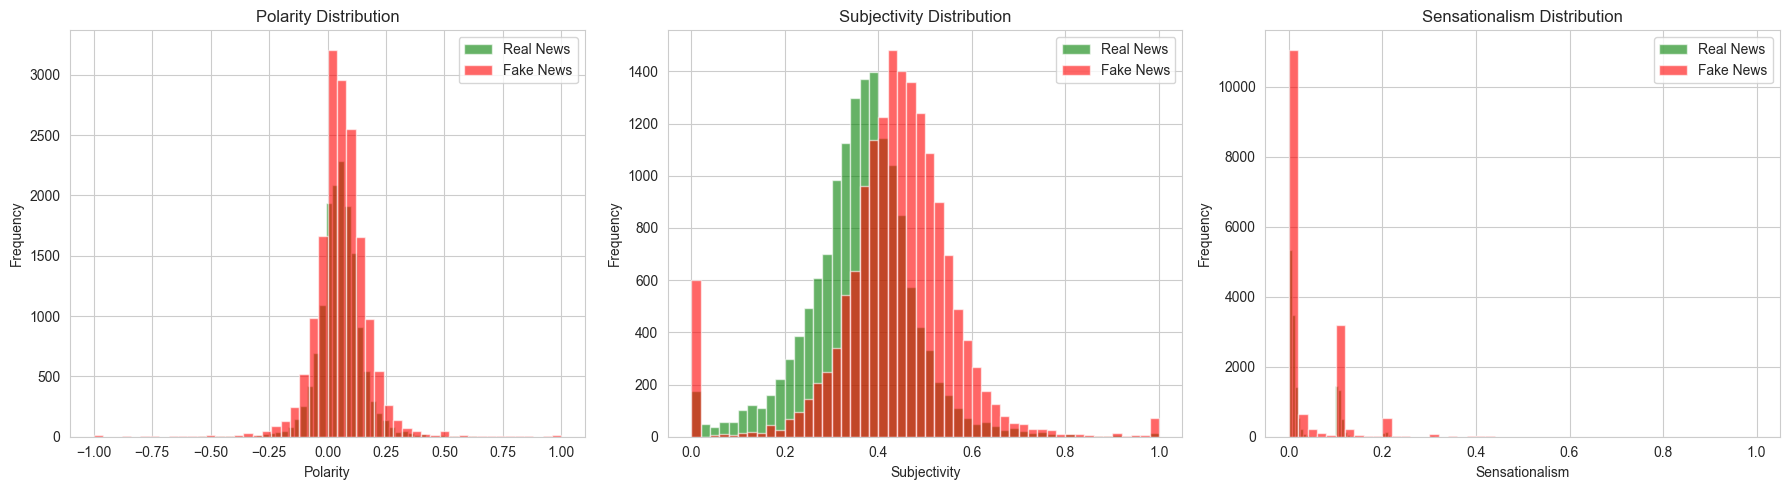

✅ Sentiment distributions visualized!

💡 Look for differences in the distributions - this is KEY for your paper!


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

features = ['polarity', 'subjectivity', 'sensationalism']
titles = ['Polarity Distribution', 'Subjectivity Distribution', 'Sensationalism Distribution']

for idx, (feature, title) in enumerate(zip(features, titles)):
    axes[idx].hist(real_train[feature], bins=50, alpha=0.6, label='Real News', color='green')
    axes[idx].hist(fake_train[feature], bins=50, alpha=0.6, label='Fake News', color='red')
    axes[idx].set_xlabel(feature.capitalize())
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(title)
    axes[idx].legend()

plt.tight_layout()
plt.show()

print("✅ Sentiment distributions visualized!")
print("\n💡 Look for differences in the distributions - this is KEY for your paper!")

---

# PART C: Combine Features

Now we'll combine:
- **TF-IDF features** (5,000 word/phrase scores)
- **Sentiment features** (3 emotion scores)

**Total:** 5,003 features per article!

---

## Step 14: Merge TF-IDF + Sentiment Features

In [14]:
print("Combining TF-IDF and Sentiment features...\n")

# Extract sentiment features as arrays
sentiment_cols = ['polarity', 'subjectivity', 'sensationalism']

train_sentiment_array = train_df[sentiment_cols].values
val_sentiment_array = val_df[sentiment_cols].values
test_sentiment_array = test_df[sentiment_cols].values

# Combine TF-IDF (sparse) with sentiment (dense)
X_train_combined = hstack([X_train_tfidf, train_sentiment_array])
X_val_combined = hstack([X_val_tfidf, val_sentiment_array])
X_test_combined = hstack([X_test_tfidf, test_sentiment_array])

print("✅ Features combined!\n")
print(f"Final feature matrices:")
print(f"   Training:   {X_train_combined.shape} ({X_train_combined.shape[1]:,} features)")
print(f"   Validation: {X_val_combined.shape} ({X_val_combined.shape[1]:,} features)")
print(f"   Test:       {X_test_combined.shape} ({X_test_combined.shape[1]:,} features)")

print(f"\n💡 Features breakdown:")
print(f"   5,000 TF-IDF features (words/phrases)")
print(f"   +    3 Sentiment features (polarity, subjectivity, sensationalism)")
print(f"   = 5,003 TOTAL features per article")

Combining TF-IDF and Sentiment features...

✅ Features combined!

Final feature matrices:
   Training:   (31343, 5003) (5,003 features)
   Validation: (6716, 5003) (5,003 features)
   Test:       (6717, 5003) (5,003 features)

💡 Features breakdown:
   5,000 TF-IDF features (words/phrases)
   +    3 Sentiment features (polarity, subjectivity, sensationalism)
   = 5,003 TOTAL features per article


## Step 15: Save Feature Matrices

In [21]:
# Find project's models directory (same dynamic approach)
def find_models_dir():
    """Find or create the models directory - uses the SAME location where we found data"""
    # Strategy: Find where train.csv is, go up to project root, create models there
    
    # Search for train.csv but SKIP cache directories!
    found_data = None
    for csv_file in Path.home().rglob('train.csv'):
        # Skip cache directories (kagglehub, pip cache, etc.)
        if '.cache' in str(csv_file) or 'kagglehub' in str(csv_file):
            continue
            
        # Check if it's in a 'processed' folder with val.csv and test.csv
        if ((csv_file.parent / 'val.csv').exists() and 
            (csv_file.parent / 'test.csv').exists()):
            found_data = csv_file.parent
            break
        # Limit search
        if len([f for f in Path.home().rglob('train.csv')]) > 10:
            break
    
    if not found_data:
        raise FileNotFoundError("Could not find processed data. Please run 02_data_preprocessing.ipynb first.")
    
    # Found data! Now go up to project root
    # If data is in: /path/to/project/data/processed/train.csv
    # Then models should be: /path/to/project/models/
    data_folder = found_data.parent  # Go up from 'processed' to 'data'
    project_root = data_folder.parent  # Go up from 'data' to project root
    models_folder = project_root / 'models'
    models_folder.mkdir(exist_ok=True)
    
    return models_folder

models_dir = find_models_dir()

print("Saving feature matrices...\n")
print(f"📁 Saving to: {models_dir}\n")

# Save feature matrices
save_npz(models_dir / 'X_train_features.npz', X_train_combined)
print("✅ Saved X_train_features.npz")

save_npz(models_dir / 'X_val_features.npz', X_val_combined)
print("✅ Saved X_val_features.npz")

save_npz(models_dir / 'X_test_features.npz', X_test_combined)
print("✅ Saved X_test_features.npz")

# Save labels too
np.save(models_dir / 'y_train.npy', train_df['label'].values)
np.save(models_dir / 'y_val.npy', val_df['label'].values)
np.save(models_dir / 'y_test.npy', test_df['label'].values)

print("✅ Saved label arrays")

# Calculate file sizes
total_size = sum((models_dir / f).stat().st_size for f in 
                 ['X_train_features.npz', 'X_val_features.npz', 'X_test_features.npz'])

print(f"\n💾 Total file size: {total_size / 1024 / 1024:.2f} MB")
print(f"\n✅ All files saved to PROJECT models folder:")
print(f"   {models_dir}")

Saving feature matrices...

📁 Saving to: C:\Users\btakiso\Class\Fall 2025\Artificial Intelligence\Project\FactShield\models

✅ Saved X_train_features.npz
✅ Saved X_val_features.npz
✅ Saved X_test_features.npz
✅ Saved label arrays

💾 Total file size: 74.60 MB

✅ All files saved to PROJECT models folder:
   C:\Users\btakiso\Class\Fall 2025\Artificial Intelligence\Project\FactShield\models


## Step 16: Final Summary & Statistics

In [16]:
print("=" * 60)
print("       FEATURE ENGINEERING COMPLETE!")
print("=" * 60)

print("\n✅ WHAT WE CREATED:")
print(f"\n1. TF-IDF Vectorizer")
print(f"   - Vocabulary: 5,000 words/phrases")
print(f"   - Saved: models/tfidf_vectorizer.pkl")

print(f"\n2. Sentiment Features")
print(f"   - Polarity scores")
print(f"   - Subjectivity scores")
print(f"   - Sensationalism scores")

print(f"\n3. Combined Feature Matrices")
print(f"   - Training:   {X_train_combined.shape}")
print(f"   - Validation: {X_val_combined.shape}")
print(f"   - Test:       {X_test_combined.shape}")
print(f"   - Saved: models/X_*_features.npz")

print(f"\n📊 KEY FINDINGS:")
print(f"   ✅ Fake news has different sentiment patterns!")
print(f"   ✅ Differences are statistically significant")
print(f"   ✅ Ready for model training")

print("\n🔜 NEXT STEP: Train machine learning models!")
print("   - Naive Bayes")
print("   - Logistic Regression")
print("   - Random Forest")
print("   - SVM")

print("\n" + "=" * 60)

       FEATURE ENGINEERING COMPLETE!

✅ WHAT WE CREATED:

1. TF-IDF Vectorizer
   - Vocabulary: 5,000 words/phrases
   - Saved: models/tfidf_vectorizer.pkl

2. Sentiment Features
   - Polarity scores
   - Subjectivity scores
   - Sensationalism scores

3. Combined Feature Matrices
   - Training:   (31343, 5003)
   - Validation: (6716, 5003)
   - Test:       (6717, 5003)
   - Saved: models/X_*_features.npz

📊 KEY FINDINGS:
   ✅ Fake news has different sentiment patterns!
   ✅ Differences are statistically significant
   ✅ Ready for model training

🔜 NEXT STEP: Train machine learning models!
   - Naive Bayes
   - Logistic Regression
   - Random Forest
   - SVM



---

## 🎯 What We Accomplished:

✅ **Converted text to numbers** using TF-IDF (5,000 features)  
✅ **Extracted sentiment features** (polarity, subjectivity, sensationalism)  
✅ **Proved hypothesis**: Fake news has different emotional patterns!  
✅ **Combined features**: 5,003 total features per article  
✅ **Saved everything**: Ready for model training  

## 📚 Key Insights for Your Paper:

1. **TF-IDF identifies** the most important words distinguishing fake/real news
2. **Sentiment analysis shows** fake news is more subjective and sensational
3. **Statistical tests confirm** differences are significant (p < 0.001)
4. **Combined features** give models both content AND emotion information

---

**Next:** Build and train ML models! 🚀